In [1]:
import fig02 as src
import pandas as pd

pd.set_option("display.float_format", "{:.4f}".format)

signature_list = ["nps", "siips", "na-gen", "na-therm", "na-mech", "na-sound", "na-vis"]

cbf = (
    pd.read_csv("../../results/cbf-ps-agg.csv")
    .query("ses == 'mri1'")
    .pipe(src.drop_outliers, "cbfQEI")
    .groupby("sub")
    .filter(lambda df: df["task"].nunique() == 2)
    .pipe(src.scale, signature_list)
    .melt(id_vars=["sub", "task"], value_vars=signature_list)
)


/usr/local/Caskroom/miniconda/base/envs/med-pain-sig/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
import pingouin as pg

(
    cbf.groupby("variable")
    .apply(lambda df: df.pairwise_tests(dv="value", within="task", subject="sub"))
    .assign(q_fdr=lambda df: pg.multicomp(df["p-unc"].values, alpha=0.05, method="fdr")[1])
)


,,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges,q_fdr
variable,,,,,,,,,,,,,
na-gen,0,task,baseline35C,baseline49C,True,True,-2.6602,76.0000,two-sided,0.0095,3.312,-0.1367,0.0111
na-mech,0,task,baseline35C,baseline49C,True,True,-2.3549,76.0000,two-sided,0.0211,1.671,-0.1592,0.0211
na-sound,0,task,baseline35C,baseline49C,True,True,3.8970,76.0000,two-sided,0.0002,102.507,0.2451,0.0004
na-therm,0,task,baseline35C,baseline49C,True,True,-4.0910,76.0000,two-sided,0.0001,190.861,-0.2186,0.0002
na-vis,0,task,baseline35C,baseline49C,True,True,3.7066,76.0000,two-sided,0.0004,56.798,0.2205,0.0006
nps,0,task,baseline35C,baseline49C,True,True,-8.3856,76.0000,two-sided,0.0000,4.148e+09,-0.6028,0.0000
siips,0,task,baseline35C,baseline49C,True,True,-12.0994,76.0000,two-sided,0.0000,2.446e+16,-0.6642,0.0000


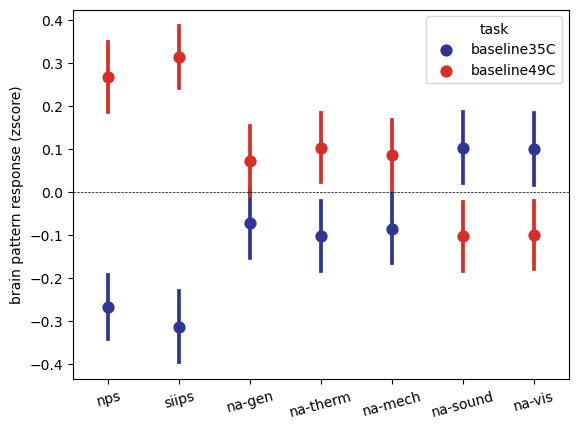

In [3]:
import seaborn as sns

cmap = sns.color_palette(["#313695", "#D62F26"], n_colors=2)
ax = sns.pointplot(
    data=cbf,
    x="variable",
    y="value",
    hue="task",
    errorbar="se",
    palette=cmap,
    order=signature_list,
    join=False,
)
ax.axhline(0, linestyle="--", lw=0.5, color="k")
ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
ax.set_ylabel("brain pattern response (zscore)")
ax.set_xlabel("")
fig = ax.get_figure()
fig.savefig("../../figures/sup01.svg")
